# Two-area Decision Making Dynamics Model

We re-implement the two-area PPC-PFC model capable of working memory and decision making from [1]. The model consists of two separate modules meant to correspond to PPC and PFC, each containing two neural populations. We will briefly analyze the resulting dynamics here.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch

/home/fpei2/miniconda3/envs/ttrnn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from model import MurraySingleArea, MurrayTwoArea
from task import PulseDiscriminationTask

In [3]:
plt.rcParams["font.family"] = "sans-serif" # annoying errors

## Single-area dynamics

We first look at the dynamics of individual modules. All modules in the paper seem to have the same "tone" $J_T$, (total input to each region), but they vary in "structure" $J_S$ (difference between inputs from itself and inputs from the other population). We focus on the two structure values used in the final two-area model, $J_S = 0.35$ and $J_S = 0.4187$, as well as a third value of interest, $J_S = 0.2$.

### Plots

We approximate the flow field by running the networks forward one step at points sampled in the state space.

In [4]:
# initialize models
model1 = MurraySingleArea(Js=0.2)
model2 = MurraySingleArea(Js=0.35)
model3 = MurraySingleArea(Js=0.4187)

In [5]:
# prepare model inputs
x, y = np.meshgrid(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01))
states = np.stack([x, y], axis=-1)
inputs = np.zeros(states.shape)
data_shape = states.shape

In [6]:
# approximate flow fields by stepping forward 1 bin
states = torch.from_numpy(states.reshape(1, -1, 2))
inputs = torch.from_numpy(inputs.reshape(-1, 1, 2))
with torch.no_grad():
    _, next_states = model1(inputs, states, steps_per_bin=1)
    diff1 = (next_states - states).detach().numpy()
    
    _, next_states = model2(inputs, states, steps_per_bin=1)
    diff2 = (next_states - states).detach().numpy()
    
    _, next_states = model3(inputs, states, steps_per_bin=1)
    diff3 = (next_states - states).detach().numpy()
    
diff1 = diff1.reshape(data_shape)
diff2 = diff2.reshape(data_shape)
diff3 = diff3.reshape(data_shape)

#### Flow field

Text(0.5, 1.0, '$J_S = 0.4187$')

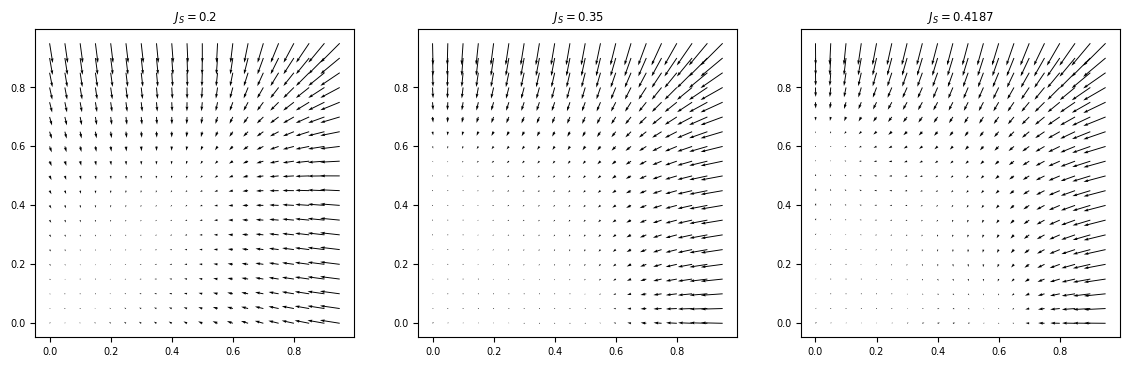

In [7]:
# plot vector field
fig, axs = plt.subplots(1, 3, figsize=(14,4))
axs[0].quiver(x[::5,::5], y[::5,::5], diff1[::5,::5,0], diff1[::5,::5,1])
axs[1].quiver(x[::5,::5], y[::5,::5], diff2[::5,::5,0], diff2[::5,::5,1])
axs[2].quiver(x[::5,::5], y[::5,::5], diff3[::5,::5,0], diff3[::5,::5,1])
axs[0].set_title("$J_S = 0.2$")
axs[1].set_title("$J_S = 0.35$")
axs[2].set_title("$J_S = 0.4187$")

#### Dynamics magnitude

Text(0.5, 1.0, '$J_S = 0.4187$')

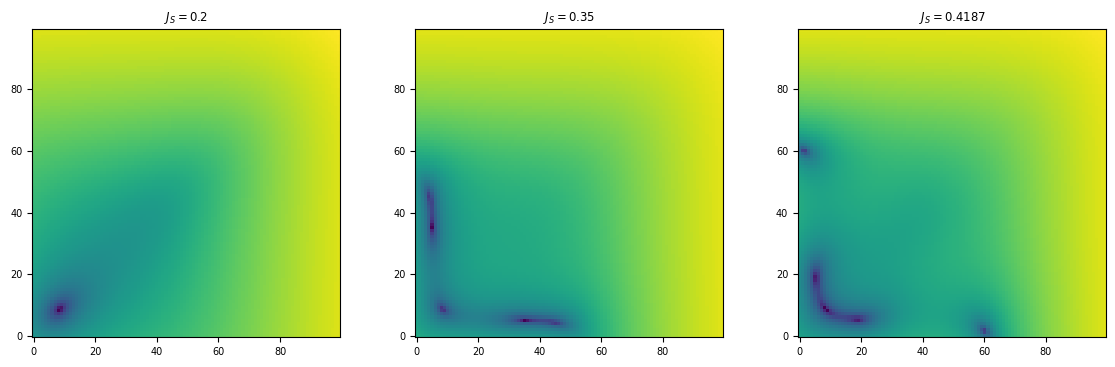

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(14,4))
lognorm1 = np.log(np.linalg.norm(diff1, axis=-1))
lognorm2 = np.log(np.linalg.norm(diff2, axis=-1))
lognorm3 = np.log(np.linalg.norm(diff3, axis=-1))
min_norm = np.min([lognorm1, lognorm2, lognorm3])
max_norm = np.max([lognorm1, lognorm2, lognorm3])
axs[0].imshow((lognorm1 - min_norm) / (max_norm - min_norm), origin='lower')
axs[1].imshow((lognorm2 - min_norm) / (max_norm - min_norm), origin='lower')
axs[2].imshow((lognorm3 - min_norm) / (max_norm - min_norm), origin='lower')
axs[0].set_title("$J_S = 0.2$")
axs[1].set_title("$J_S = 0.35$")
axs[2].set_title("$J_S = 0.4187$")

Text(0.5, 1.0, '$J_S = 0.4187$')

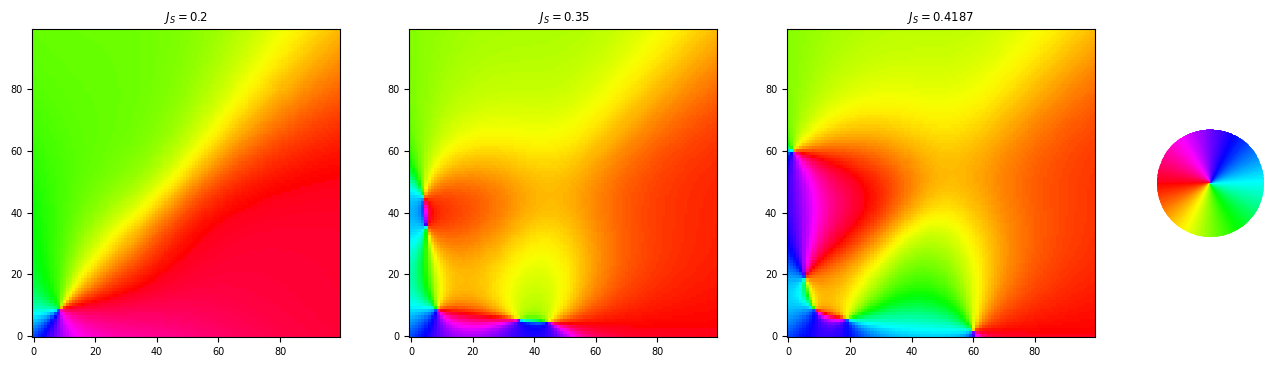

In [9]:
fig = plt.figure(figsize=(16,4))
gs = matplotlib.gridspec.GridSpec(1, 4, width_ratios=[3, 3, 3, 1]) 

axs = [plt.subplot(gs[i]) for i in range(3)]
angles1 = np.arctan2(diff1[:,:,1], diff1[:,:,0]) / (2 * np.pi) + 0.5
angles2 = np.arctan2(diff2[:,:,1], diff2[:,:,0]) / (2 * np.pi) + 0.5
angles3 = np.arctan2(diff3[:,:,1], diff3[:,:,0]) / (2 * np.pi) + 0.5
axs[0].imshow(angles1, origin='lower', cmap=plt.cm.hsv)
axs[1].imshow(angles2, origin='lower', cmap=plt.cm.hsv)
axs[2].imshow(angles3, origin='lower', cmap=plt.cm.hsv)

ax_wheel = plt.subplot(gs[-1], projection='polar')
ax_wheel._direction = 2*np.pi 
norm = matplotlib.colors.Normalize(-np.pi, np.pi)
cb = matplotlib.colorbar.ColorbarBase(
    ax_wheel, cmap=matplotlib.colormaps.get_cmap('hsv'),
    norm=norm, orientation='horizontal')                                  
cb.outline.set_visible(False)                                 
ax_wheel.set_axis_off()

axs[0].set_title("$J_S = 0.2$")
axs[1].set_title("$J_S = 0.35$")
axs[2].set_title("$J_S = 0.4187$")

### Analysis

At $J_S = 0.2$, we see that there is only one stable fixed point near $(0.1, 0.1)$. Then, there is approximately a very leaky "line attractor" along the line $y = x$. 

At $J_S = 0.35$, we now see five fixed points. The one near the origin remains, but now along both the $x$ and $y$ axes, there are two new fixed points each, forming an overall "L" shape. Along each separate line of the "L", we have relatively slow dynamics. Considering only one of the lines, between the origin fixed point and the nearer of the two other fixed points, we have dynamics that overall attract to the line and attract toward the origin fixed point, again resulting in leaky "line attractor" dynamics. Between the two other fixed points, we have again weak "line attractor" dynamics that flow towards the further fixed point. So, the middle fixed point is a stable along the direction perpendicular to the line, but unstable along the line. The dynamics in the segment between the origin and the middle fixed point appear to be stronger in magnitude than in the other segment, due to the distance between the fixed points.

At $J_S = 0.4187$, we again have five fixed points, but the middle fixed points have moved closer to the origin fixed point. The dynamics between the fixed points remain the same, but now because the middle fixed point is closer to the origin and further from the other fixed point, the dynamics between the middle and further fixed point are stronger in magnitude than between the origin and middle.

So, to summarize, at $J_S = 0.2$ we only have a stable fixed point near the origin, and the entire state space decays toward that point, though there is a weak tendency to attract towards the central line $y = x$ also. At $J_S = 0.35$, we have stable fixed points arranged in an "L" shape. However, the saddle point between the two is quite far from the origin so it is relatively difficult to push over it and enter the other stable points. At $J_S = 0.4187$, the saddle point moves much closer to the origin and thus it is much easier to push the network into the other stable states. In both $J_S = 0.35$ and $J_S = 0.4187$, dynamics tend to attract toward the "L" of fixed points.

## Two-area dynamics

In the proposed two-area model, the upstream region (PPC) has $J_S = 0.35$ while the downstream region (PFC) has $J_S = 0.4187$. You can probably imagine how this might work. The PPC implements leaky integration of inputs, and then, once that value hits a threshold where it is sufficient to push the PFC network out into one of its other stable states, the decision is made.

### Single-area input-dependent dynamics

It might be helpful to re-do the above plots depending on the input that the area receives. The two-area model has symmetric connectivity, so the feedforward and feedback inputs to the two populations in each area are always of the opposite sign. The strength ("structure") of the feedforward connectivity is 0.15 (so 0.075 and -0.075), and the strength of the feedback connectivity is 0.04 (so 0.02 and -0.02). We can see how dynamics change with respect to input at each of these strengths.

Note that the "input" or "input strength" in all plots below is the **difference** between population A and B.

#### Strong input connectivity

In [10]:
x, y = np.meshgrid(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01))
states = np.stack([x, y], axis=-1)
data_shape = states.shape

states = torch.from_numpy(states.reshape(1, -1, 2))
context_diff1 = []
context_diff2 = []
context_diff3 = []

input_strengths = np.arange(0.0, 0.7, 0.1).tolist()

for input_strength in input_strengths:
    inputs = np.ones(states.shape) * 0.075 * np.array([input_strength, -input_strength])[None, None, :]
    inputs = torch.from_numpy(inputs.reshape(-1, 1, 2))

    with torch.no_grad():
        _, next_states = model1(inputs, states, steps_per_bin=1)
        diff1 = (next_states - states).detach().numpy()
        
        _, next_states = model2(inputs, states, steps_per_bin=1)
        diff2 = (next_states - states).detach().numpy()
        
        _, next_states = model3(inputs, states, steps_per_bin=1)
        diff3 = (next_states - states).detach().numpy()
        
    diff1 = diff1.reshape(data_shape)
    diff2 = diff2.reshape(data_shape)
    diff3 = diff3.reshape(data_shape)

    context_diff1.append(diff1)
    context_diff2.append(diff2)
    context_diff3.append(diff3)

Text(0.5, 1.0, '$J_S = 0.4187$')

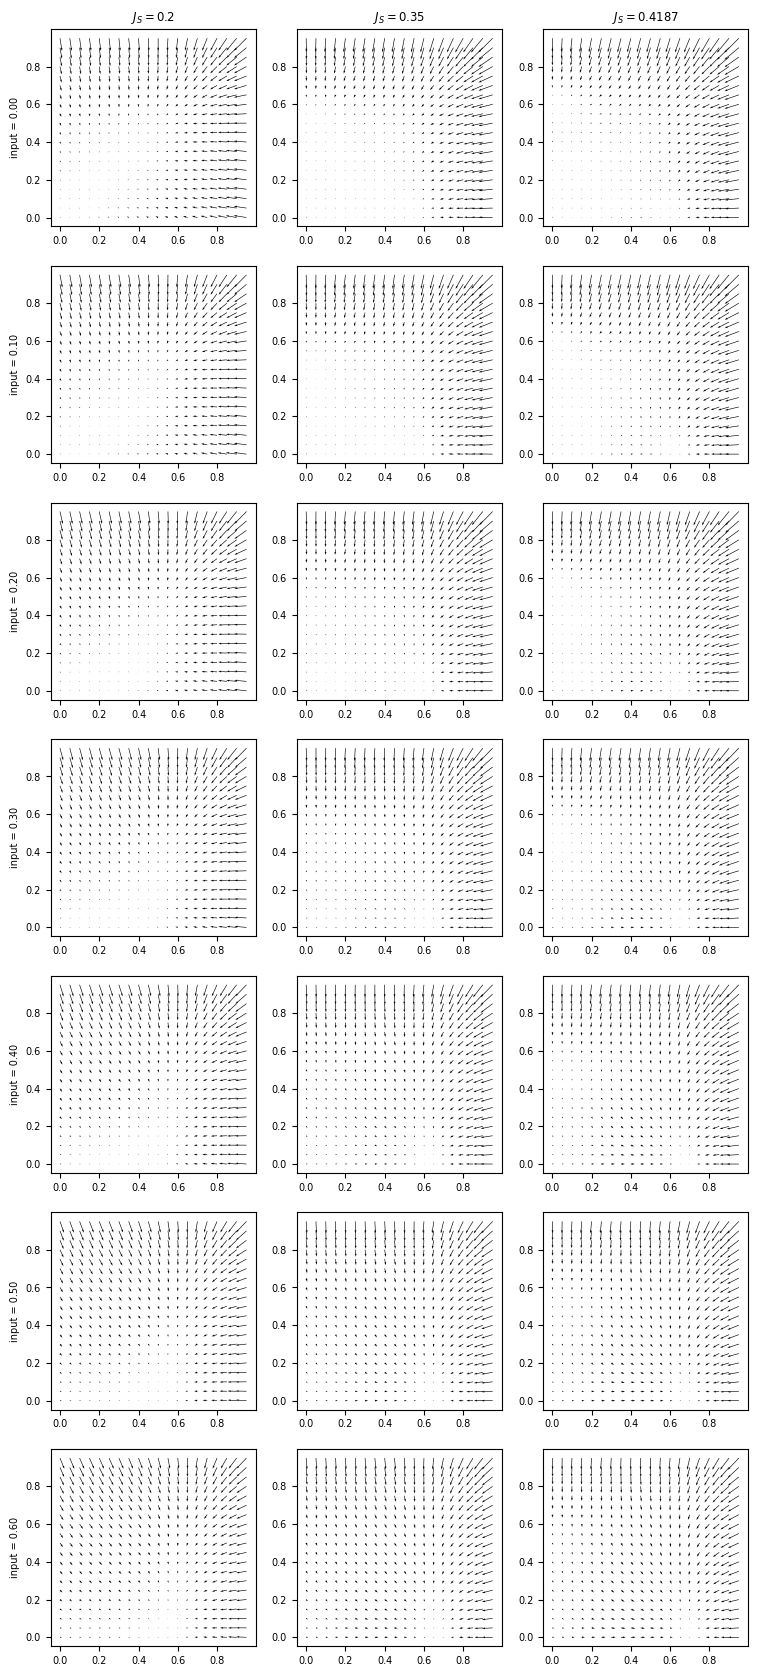

In [11]:
# plot vector field
fig, axs = plt.subplots(len(input_strengths), 3, figsize=(9,3*len(input_strengths)))

for i in range(len(input_strengths)):
    axs[i,0].set_ylabel(f"input = {input_strengths[i]:.2f}")
    axs[i,0].quiver(x[::5,::5], y[::5,::5], context_diff1[i][::5,::5,0], context_diff1[i][::5,::5,1])
    axs[i,1].quiver(x[::5,::5], y[::5,::5], context_diff2[i][::5,::5,0], context_diff2[i][::5,::5,1])
    axs[i,2].quiver(x[::5,::5], y[::5,::5], context_diff3[i][::5,::5,0], context_diff3[i][::5,::5,1])

axs[0,0].set_title("$J_S = 0.2$")
axs[0,1].set_title("$J_S = 0.35$")
axs[0,2].set_title("$J_S = 0.4187$")

Text(0.5, 1.0, '$J_S = 0.4187$')

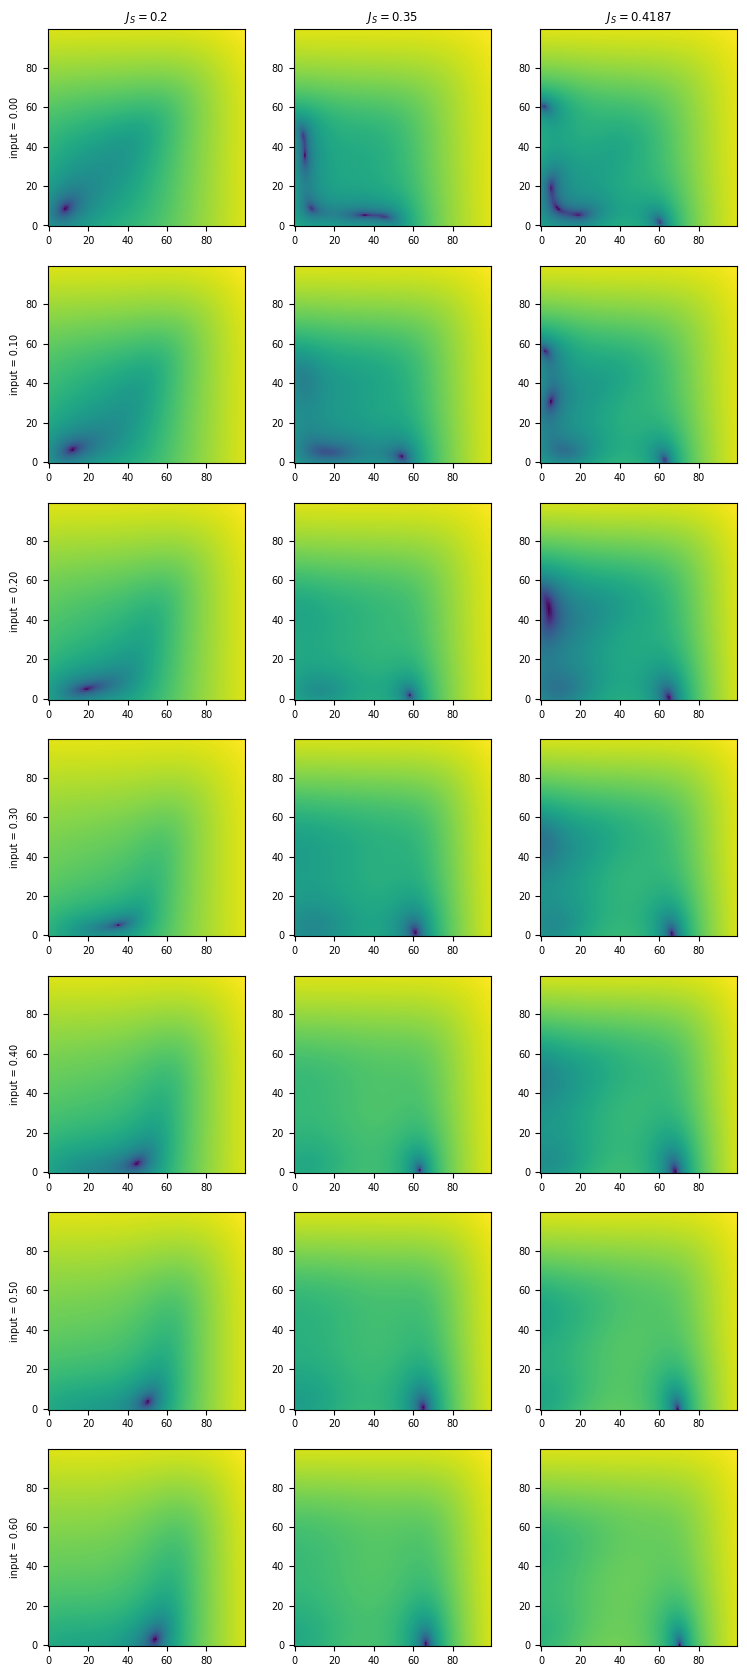

In [12]:
fig, axs = plt.subplots(len(input_strengths), 3, figsize=(9,3*len(input_strengths)))

for i in range(len(input_strengths)):
    lognorm1 = np.log(np.linalg.norm(context_diff1[i], axis=-1))
    lognorm2 = np.log(np.linalg.norm(context_diff2[i], axis=-1))
    lognorm3 = np.log(np.linalg.norm(context_diff3[i], axis=-1))
    min_norm = np.min([lognorm1, lognorm2, lognorm3])
    max_norm = np.max([lognorm1, lognorm2, lognorm3])
    axs[i,0].set_ylabel(f"input = {input_strengths[i]:.2f}")
    axs[i,0].imshow((lognorm1 - min_norm) / (max_norm - min_norm), origin='lower')
    axs[i,1].imshow((lognorm2 - min_norm) / (max_norm - min_norm), origin='lower')
    axs[i,2].imshow((lognorm3 - min_norm) / (max_norm - min_norm), origin='lower')

axs[0,0].set_title("$J_S = 0.2$")
axs[0,1].set_title("$J_S = 0.35$")
axs[0,2].set_title("$J_S = 0.4187$")

Text(0.5, 1.0, '$J_S = 0.4187$')

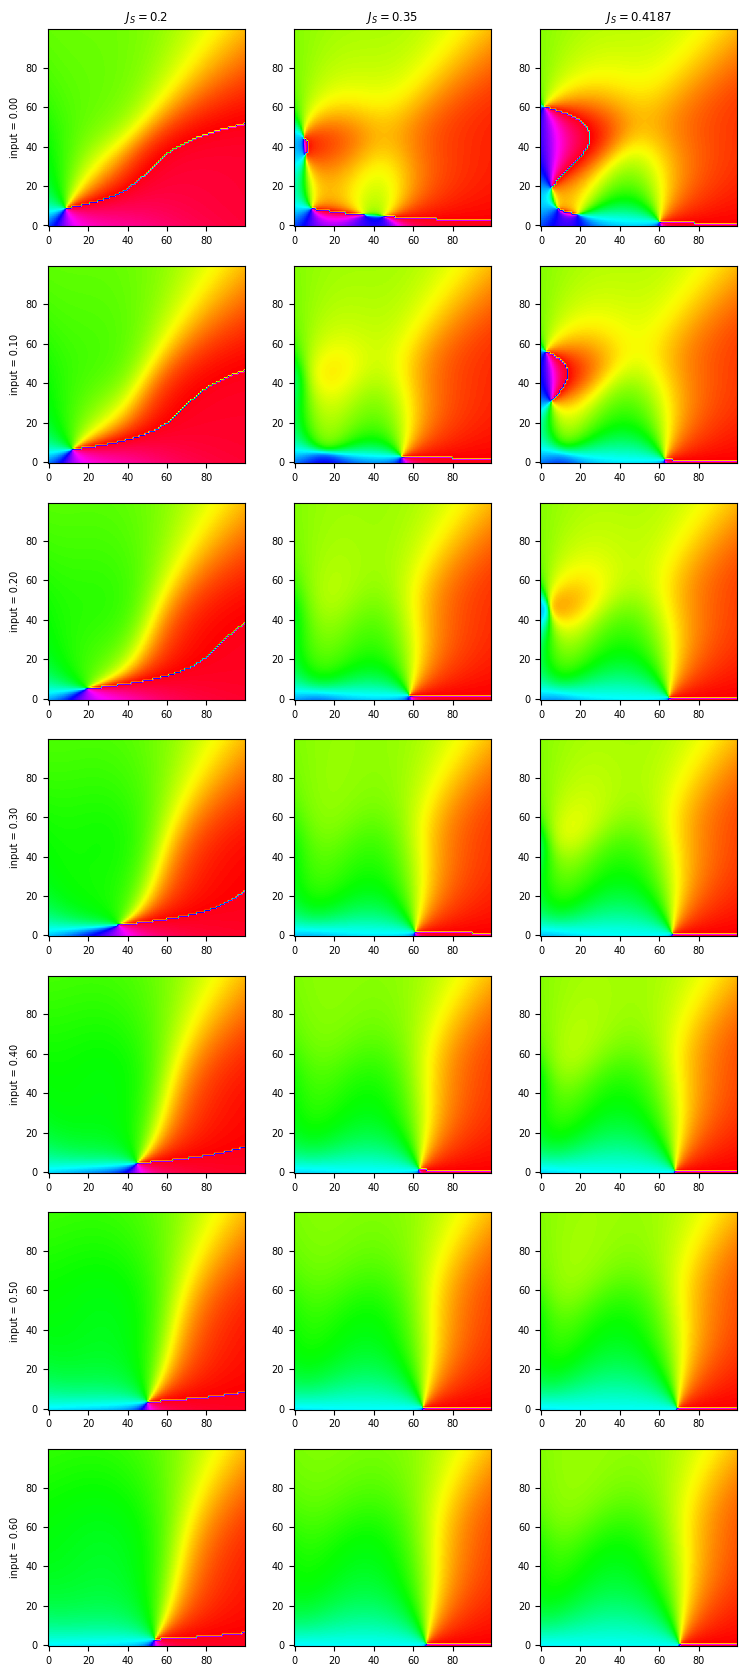

In [13]:
fig, axs = plt.subplots(len(input_strengths), 3, figsize=(9,3*len(input_strengths)))

for i in range(len(input_strengths)):
    angles1 = np.arctan2(context_diff1[i][:,:,1], context_diff1[i][:,:,0]) / (2 * np.pi) + 0.5
    angles2 = np.arctan2(context_diff2[i][:,:,1], context_diff2[i][:,:,0]) / (2 * np.pi) + 0.5
    angles3 = np.arctan2(context_diff3[i][:,:,1], context_diff3[i][:,:,0]) / (2 * np.pi) + 0.5
    axs[i,0].set_ylabel(f"input = {input_strengths[i]:.2f}")
    axs[i,0].imshow(angles1, origin='lower', cmap=plt.cm.hsv)
    axs[i,1].imshow(angles2, origin='lower', cmap=plt.cm.hsv)
    axs[i,2].imshow(angles3, origin='lower', cmap=plt.cm.hsv)

axs[0,0].set_title("$J_S = 0.2$")
axs[0,1].set_title("$J_S = 0.35$")
axs[0,2].set_title("$J_S = 0.4187$")

I do not know why there are weird lines on the angle plot. Also, the color scales for the different input conditions on the log-norm dynamics plot are not the same.

##### Strong input connectivity analysis

So, inputs clearly destroy drive the formation of one single fixed point along the direction of positive input. The network with stronger internal connectivity actually seems more robust to this and maintains its other fixed points for slightly longer. However, the weaker network is the one that receives weaker input also in the two-area model. 

Anyway, this seems to suggest that once the upstream area reaches a certain (fairly low) threshold, the downstream network converges toward a decision. But, the upstream network likely has to maintain its level of activity for some time. The downstream network reaching its decision also helps drive the upstream network more to reinforce that decision, though the effect is relatively weak. Still, it should be comparable to the input = 0.2 condition ((0.6 or 0.7) * 0.02 = (0.12 or 0.14) = 0.2ish * 0.075), which has a pretty strong single fixed point already.

#### Weak input connectivity

In [14]:
x, y = np.meshgrid(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01))
states = np.stack([x, y], axis=-1)
data_shape = states.shape

states = torch.from_numpy(states.reshape(1, -1, 2))
context_diff1 = []
context_diff2 = []
context_diff3 = []

input_strengths = np.arange(0.0, 0.7, 0.1).tolist()

for input_strength in input_strengths:
    inputs = np.ones(states.shape) * 0.02 * np.array([input_strength, -input_strength])[None, None, :]
    inputs = torch.from_numpy(inputs.reshape(-1, 1, 2))

    with torch.no_grad():
        _, next_states = model1(inputs, states, steps_per_bin=1)
        diff1 = (next_states - states).detach().numpy()
        
        _, next_states = model2(inputs, states, steps_per_bin=1)
        diff2 = (next_states - states).detach().numpy()
        
        _, next_states = model3(inputs, states, steps_per_bin=1)
        diff3 = (next_states - states).detach().numpy()
        
    diff1 = diff1.reshape(data_shape)
    diff2 = diff2.reshape(data_shape)
    diff3 = diff3.reshape(data_shape)

    context_diff1.append(diff1)
    context_diff2.append(diff2)
    context_diff3.append(diff3)

Text(0.5, 1.0, '$J_S = 0.4187$')

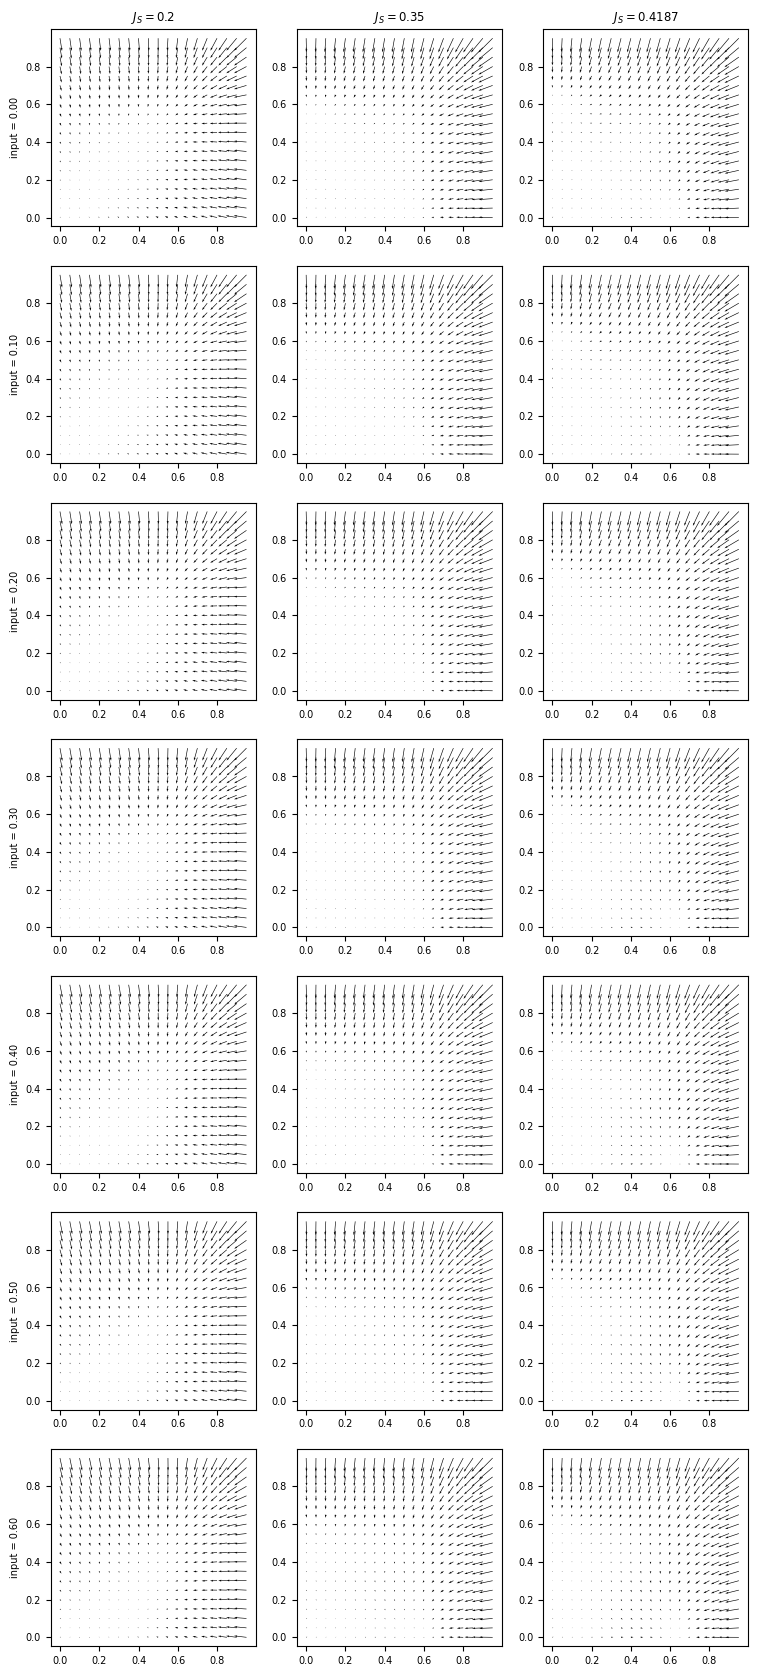

In [15]:
# plot vector field
fig, axs = plt.subplots(len(input_strengths), 3, figsize=(9,3*len(input_strengths)))

for i in range(len(input_strengths)):
    axs[i,0].set_ylabel(f"input = {input_strengths[i]:.2f}")
    axs[i,0].quiver(x[::5,::5], y[::5,::5], context_diff1[i][::5,::5,0], context_diff1[i][::5,::5,1])
    axs[i,1].quiver(x[::5,::5], y[::5,::5], context_diff2[i][::5,::5,0], context_diff2[i][::5,::5,1])
    axs[i,2].quiver(x[::5,::5], y[::5,::5], context_diff3[i][::5,::5,0], context_diff3[i][::5,::5,1])

axs[0,0].set_title("$J_S = 0.2$")
axs[0,1].set_title("$J_S = 0.35$")
axs[0,2].set_title("$J_S = 0.4187$")

Text(0.5, 1.0, '$J_S = 0.4187$')

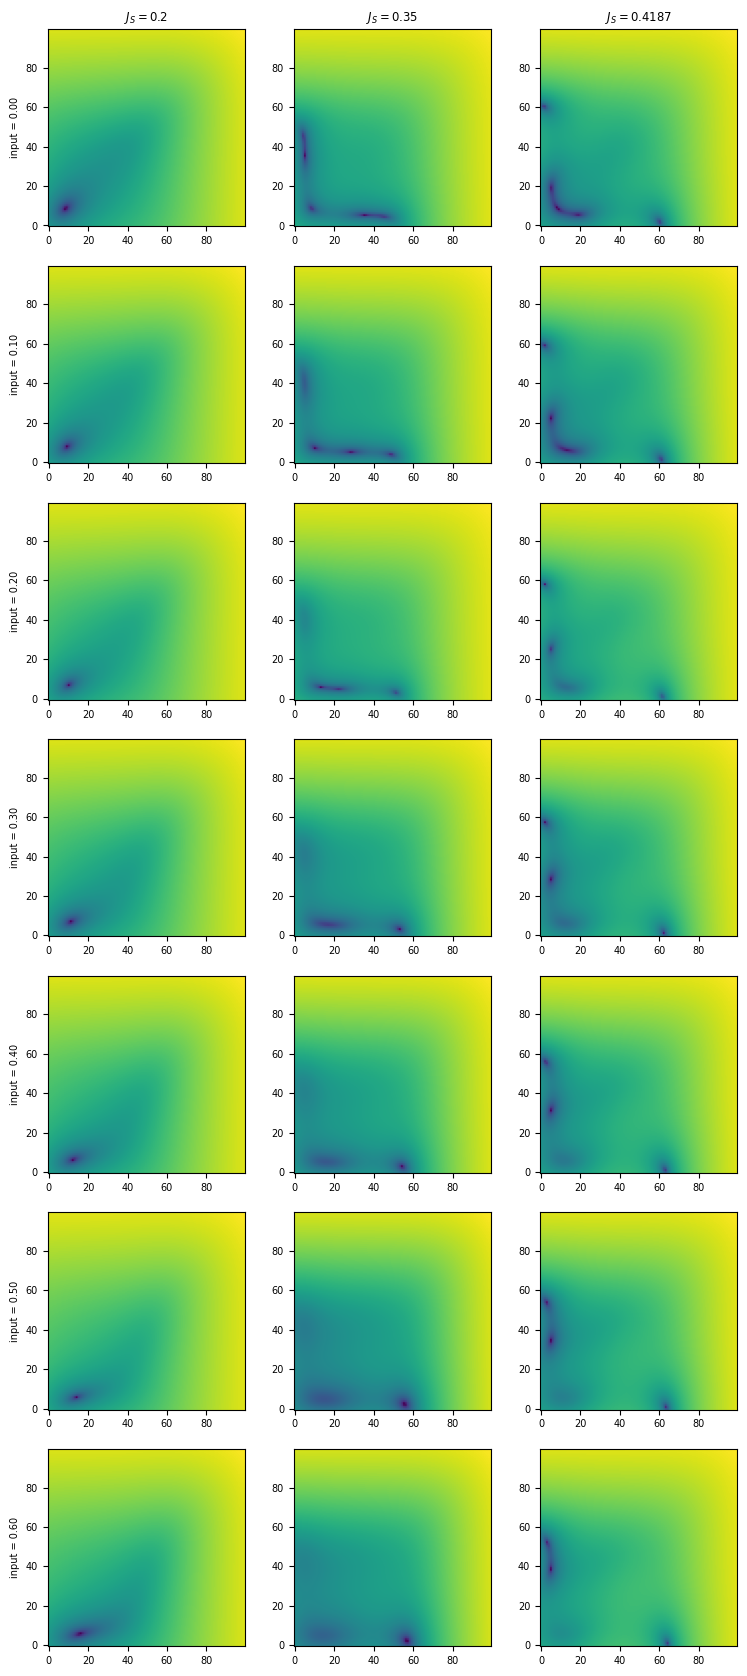

In [16]:
fig, axs = plt.subplots(len(input_strengths), 3, figsize=(9,3*len(input_strengths)))

for i in range(len(input_strengths)):
    lognorm1 = np.log(np.linalg.norm(context_diff1[i], axis=-1))
    lognorm2 = np.log(np.linalg.norm(context_diff2[i], axis=-1))
    lognorm3 = np.log(np.linalg.norm(context_diff3[i], axis=-1))
    min_norm = np.min([lognorm1, lognorm2, lognorm3])
    max_norm = np.max([lognorm1, lognorm2, lognorm3])
    axs[i,0].set_ylabel(f"input = {input_strengths[i]:.2f}")
    axs[i,0].imshow((lognorm1 - min_norm) / (max_norm - min_norm), origin='lower')
    axs[i,1].imshow((lognorm2 - min_norm) / (max_norm - min_norm), origin='lower')
    axs[i,2].imshow((lognorm3 - min_norm) / (max_norm - min_norm), origin='lower')

axs[0,0].set_title("$J_S = 0.2$")
axs[0,1].set_title("$J_S = 0.35$")
axs[0,2].set_title("$J_S = 0.4187$")

Text(0.5, 1.0, '$J_S = 0.4187$')

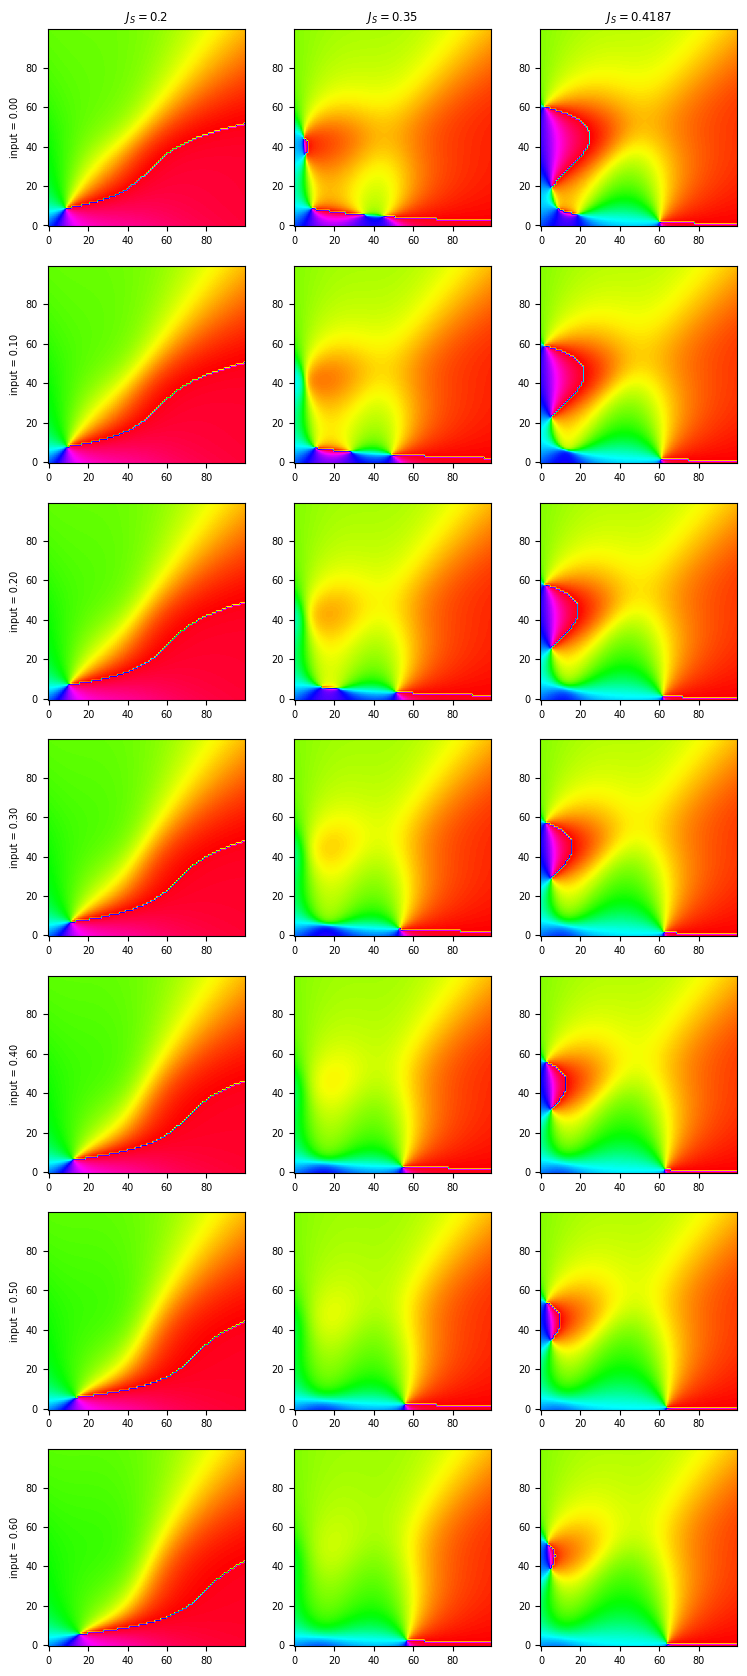

In [17]:
fig, axs = plt.subplots(len(input_strengths), 3, figsize=(9,3*len(input_strengths)))

for i in range(len(input_strengths)):
    angles1 = np.arctan2(context_diff1[i][:,:,1], context_diff1[i][:,:,0]) / (2 * np.pi) + 0.5
    angles2 = np.arctan2(context_diff2[i][:,:,1], context_diff2[i][:,:,0]) / (2 * np.pi) + 0.5
    angles3 = np.arctan2(context_diff3[i][:,:,1], context_diff3[i][:,:,0]) / (2 * np.pi) + 0.5
    axs[i,0].set_ylabel(f"input = {input_strengths[i]:.2f}")
    axs[i,0].imshow(angles1, origin='lower', cmap=plt.cm.hsv)
    axs[i,1].imshow(angles2, origin='lower', cmap=plt.cm.hsv)
    axs[i,2].imshow(angles3, origin='lower', cmap=plt.cm.hsv)

axs[0,0].set_title("$J_S = 0.2$")
axs[0,1].set_title("$J_S = 0.35$")
axs[0,2].set_title("$J_S = 0.4187$")

## References

[1] Murray JD, Jaramillo J, Wang XJ. "Working Memory and Decision-Making in a Frontoparietal Circuit Model", *The Journal of Neuroscience*, 2017. [Paper Link](https://www.jneurosci.org/content/jneuro/37/50/12167.full.pdf)